```` 
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/
https://sailajakarra.medium.com/lstm-for-time-series-predictions-cc68cc11ce4f
 ````

In [25]:
# get data
import pandas as pd
df = pd.read_csv("./data/differenced_df.csv", index_col=0, parse_dates=True)
df.head()


,close,open,high,low,estimated-transaction-volume-usd,n-transactions,hash-rate,difficulty,cost-per-transaction,Gold price,output-volume,trade-volume,USD-CNY Price,SVI,Wikiviews
0,15470.656119,15446.307986,15900.046760,14932.582596,2.004009e+09,282361.699343,7.478909e+07,1.034516e+13,72.066568,1377.316553,1.084341e+06,3.828892e+08,6.72991,7.000000,3139
1,20.290015,31.511729,27.977000,33.278400,1.131921e+08,110449.000000,6.316950e+04,0.000000e+00,-3.563874,-82.716553,1.573982e+06,2.832723e+06,0.21509,18.574713,9165
2,18.381003,20.287779,4.159823,19.578350,6.177315e+07,10713.000000,6.316950e+04,0.000000e+00,0.064860,1.000000,1.950525e+06,1.502055e+06,0.01600,18.574713,12354
3,100.489436,18.382769,109.744904,21.750954,9.192380e+07,26978.000000,-1.579238e+05,0.000000e+00,-0.414935,-8.300000,2.482038e+06,1.016058e+06,-0.02590,18.574713,10757
4,-134.379897,100.489420,18.829302,-152.846166,1.321019e+08,-40141.000000,-2.210933e+05,0.000000e+00,-0.087133,0.100000,2.998215e+06,1.452953e+07,-0.04510,18.574713,11938


In [26]:
type(df.index)

pandas.core.indexes.numeric.Int64Index

In [27]:
# prepare data
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# get dataset
values = df.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [28]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t)
1,0.692236,0.688081,0.695887,0.684940,0.957808,1.000000,1.000000,1.000000,0.894101,1.000000,...,0.592718,0.510186,0.293512,0.509416,0.224679,0.047789,0.349364,0.093454,0.15182,0.058838
2,0.500800,0.495496,0.500765,0.495956,0.642192,0.592718,0.510186,0.293512,0.509416,0.224679,...,0.356432,0.510186,0.293512,0.527873,0.269135,0.063409,0.349117,0.065750,0.15182,0.083439
3,0.500776,0.495355,0.500473,0.495782,0.590685,0.356432,0.510186,0.293512,0.527873,0.269135,...,0.394965,0.508736,0.293512,0.525433,0.264196,0.085457,0.349027,0.059920,0.15182,0.071119
4,0.501794,0.495332,0.501771,0.495810,0.621370,0.394965,0.508736,0.293512,0.525433,0.264196,...,0.235952,0.508322,0.293512,0.527100,0.268657,0.106870,0.351540,0.057248,0.15182,0.080230
5,0.498883,0.496357,0.500653,0.493595,0.656438,0.235952,0.508322,0.293512,0.527100,0.268657,...,0.468233,0.511945,0.293512,0.521722,0.269241,0.111119,0.351101,0.067796,0.15182,0.067833


In [29]:
# split data
values = reframed.values
n_train_days = 365 * 4
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1460, 1, 29) (1460,) (365, 1, 29) (365,)


In [ ]:
(train_X.shape[0], 1, train_X.shape[1])


Epoch 1/60
21/21 - 1s - loss: 0.0656 - val_loss: 0.0927
Epoch 2/60
21/21 - 0s - loss: 0.0663 - val_loss: 0.0580
Epoch 3/60
21/21 - 0s - loss: 0.0543 - val_loss: 0.0612
Epoch 4/60
21/21 - 0s - loss: 0.0541 - val_loss: 0.0579
Epoch 5/60
21/21 - 0s - loss: 0.0526 - val_loss: 0.0552
Epoch 6/60
21/21 - 0s - loss: 0.0517 - val_loss: 0.0523
Epoch 7/60
21/21 - 0s - loss: 0.0503 - val_loss: 0.0508
Epoch 8/60
21/21 - 0s - loss: 0.0497 - val_loss: 0.0478
Epoch 9/60
21/21 - 0s - loss: 0.0481 - val_loss: 0.0471
Epoch 10/60
21/21 - 0s - loss: 0.0476 - val_loss: 0.0452
Epoch 11/60
21/21 - 0s - loss: 0.0465 - val_loss: 0.0439
Epoch 12/60
21/21 - 0s - loss: 0.0457 - val_loss: 0.0430
Epoch 13/60
21/21 - 0s - loss: 0.0453 - val_loss: 0.0413
Epoch 14/60
21/21 - 0s - loss: 0.0444 - val_loss: 0.0406
Epoch 15/60
21/21 - 0s - loss: 0.0440 - val_loss: 0.0394
Epoch 16/60
21/21 - 0s - loss: 0.0433 - val_loss: 0.0383
Epoch 17/60
21/21 - 0s - loss: 0.0425 - val_loss: 0.0378
Epoch 18/60
21/21 - 0s - loss: 0.0423 - 

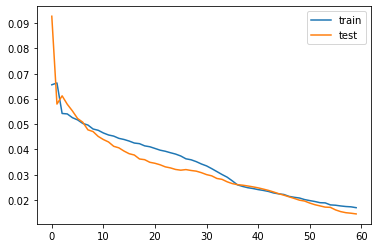

In [30]:
# create model
# design network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

try:
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=60, batch_size=72,
                        validation_data=(test_X, test_y), verbose=2, shuffle=False)

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
except Exception as e:
    print("Error: ", e)

In [31]:
model.input_shape, test_X.shape

((None, 1, 29), (365, 1, 29))

In [32]:
try:
    yhat = model.predict(test_X[0])
    print(yhat)
except Exception as e:
    print("Error: ")
    print(e)

Error: 
in user code:

    C:\Users\dell-2019\Anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\dell-2019\Anaconda3\envs\ML\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\dell-2019\Anaconda3\envs\ML\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\dell-2019\Anaconda3\envs\ML\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\dell-2019\Anaconda3\envs\ML\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\dell-2019\Anaconda3\envs\ML\lib\sit

In [33]:
# model summary
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import concatenate
try:
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
except Exception as e:
    print("Error: ", e)

Error:  operands could not be broadcast together with shapes (365,29) (15,) (365,29) 
